# Analysis of Temperature and Precipitation Data for the Central Africa Republic (1901-2022)

## Introduction
In this Jupyter Notebook, we will analyze historical temperature and precipitation data for cars from 1901 to 2022. The data has been collected from various sources and is in a tabular format.

## Data Sources
- Temperature data: https://crudata.uea.ac.uk/cru/data/hrg/
- Precipitation data: https://crudata.uea.ac.uk/cru/data/hrg/

## Data Loading
We'll start by loading the NetCDF (.nc) data from Climatic Research Unit (CRU).
Perform data wrangling and plot the data

In [148]:
# Import Relevant Dependencies
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
def read_file(filepath:str):

    """
    Reads a NetCDF file and provides information about its dimensions and variables.

    Args:
        filepath (str): The path to the NetCDF file to be read.

    Returns:
        dataset (netCDF4.Dataset): The opened NetCDF dataset.
    """
    # Read the dataset
    dataset = nc.Dataset(filepath, 'r')  # 'r' for read mode

    # Print out its variables and dimensions
    dimensions = dataset.dimensions
    for dim_name, dim_obj in dimensions.items():
        print(f"Dimension: {dim_name}, Size: {len(dim_obj)}")

    variables = dataset.variables
    for var_name, var_obj in variables.items():
        print(f"Variable name: {var_name}, Shape: {var_obj.shape}")

    return dataset

In [150]:
def extract_data(dataset:object, var:str):
    """
    Extracts and processes data for a specific variable within the CAR bounding box.

    Args:
        dataset (object): The NetCDF dataset containing the data.
        var (str): The name of the variable to extract.

    Returns:
        data_df (pd.DataFrame): A Pandas DataFrame containing the extracted data.
    """
    # Define the CAR bounding box
    car_lat_min, car_lat_max = 6.6111, 11.0
    car_lon_min, car_lon_max = 14.4167, 27.0

    # Access latitude and longitude arrays
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]

    # Find indices for CAR region
    lat_indices = np.where((lats >= car_lat_min) & (lats <= car_lat_max))[0]
    lon_indices = np.where((lons >= car_lon_min) & (lons <= car_lon_max))[0]

    # Access time variable and convert to datetime objects
    time_var = dataset.variables['time']
    times = nc.num2date(time_var[:], units=time_var.units)

    # Access specific data for the selected latitude, longitude, and time indices
    selected_data = dataset.variables[var][:, lat_indices, lon_indices]

    # Get shape (dimensions' sizes) for the selected data
    data_shape = selected_data.shape
    # print(f"Data shape: {data_shape}")

    # Create a list of dictionaries for DataFrame creation
    data_list = []

    for time_idx, time in enumerate(times):
        for lat_idx, lat in enumerate(lats[lat_indices]):
            for lon_idx, lon in enumerate(lons[lon_indices]):
                value = selected_data[time_idx, lat_idx, lon_idx]
                data_list.append({'Time': time, 'Latitude': lat, 'Longitude': lon, var: value})

    # Create a Pandas DataFrame from the list of dictionaries
    data_df = pd.DataFrame(data_list)

    return data_df

In [151]:
def add_time_metadata_to_dataframe(dataframe:pd.DataFrame):
    """
        Adds time-related metadata columns to a DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame to which time metadata will be added.

    Returns:
        dataframe (pd.DataFrame): The DataFrame with added time-related metadata columns.
    """
    # Convert 'Time' column to strings and then extract date part
    dataframe['Time'] = dataframe['Time'].astype(str).str.split(' ', expand=True)[0]
    # Convert 'Time' column to datetime objects
    dataframe['Time'] = pd.to_datetime(dataframe['Time'])
    # Extract year from the 'Time' column
    dataframe['Year'] = dataframe['Time'].dt.year
    dataframe['Month'] = dataframe['Time'].dt.month_name()
    
    return dataframe

In [152]:
def add_stats_metadata_to_dataframe(dataframe:pd.DataFrame, var:str, group_var: str):
    """
    Adds statistical metadata columns to a DataFrame based on a specified variable and grouping variable.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        var (str): The variable for which statistics will be calculated.
        group_var (str): The variable by which the data will be grouped (e.g., 'Year').

    Returns:
        statistics_df (pd.DataFrame): A DataFrame containing statistical metadata.
    """
    # Filter out rows where 'pre' is not equal to 0.00
    dataframe = dataframe[dataframe[var] != 0.00]

    # Group the data by year
    grouped_data = dataframe.groupby(group_var)[var]
    

    # Calculate statistics for each year
    temperature_statistics = grouped_data.agg(['min', 'max', 'mean'])

    # Create a new DataFrame to store the statistics
    statistics_df = pd.DataFrame({
        group_var: temperature_statistics.index,
        'Min': temperature_statistics['min'],
        'Max': temperature_statistics['max'],
        'Mean': temperature_statistics['mean']
    })
    # Reset the index to remove the 'Year' index and make it a regular column
    statistics_df = statistics_df.reset_index(drop=True)

    # Calculate rolling means for mean, min, and max temperatures
    statistics_df['Rolling_Mean_Min'] = statistics_df['Min'].rolling(window=5, min_periods=1).mean()
    statistics_df['Rolling_Mean_Max'] = statistics_df['Max'].rolling(window=5, min_periods=1).mean()
    statistics_df['Rolling_Mean_Mean'] = statistics_df['Mean'].rolling(window=5, min_periods=1).mean()

    return statistics_df

In [153]:
def plot_linegraph(dataframe:pd.DataFrame, label1:str, label2:str, label3: str, label4:str, title:str, y_label:str, list_of_colours:list):
    """
    Plots a line graph using Seaborn with specified labels, title, and custom colors.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data to be plotted.
        label1 (str): Label for the first line.
        label2 (str): Label for the second line.
        label3 (str): Label for the third line.
        label4 (str): Label for the fourth line.
        title (str): Title for the plot.
        y_label (str): Label for the y-axis.
        list_of_colours (list): List of custom colors for the lines.

    Returns:
        None
    """
    # Custom color list
    custom_colors = list_of_colours

    # Set custom colors as the color palette
    sns.set_palette(custom_colors)

    # Create a plot using Seaborn with markers and rolling means (without lines)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dataframe, x='Year', y='Min', label=label1, marker='o')
    sns.lineplot(data=dataframe, x='Year', y='Max', label=label2, marker='o')
    sns.lineplot(data=dataframe, x='Year', y='Mean', label=label3, marker='o')
    sns.lineplot(data=dataframe, x='Year', y='Rolling_Mean_Min', label=label4, color='black')
    sns.lineplot(data=dataframe, x='Year', y='Rolling_Mean_Max',  color='black')
    sns.lineplot(data=dataframe, x='Year', y='Rolling_Mean_Mean',  color='black')
    plt.xlabel('Year')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.15))
    plt.xticks(range(1901, 2023, 10))  # Customize x-axis tick labels
    sns.despine()  # Remove the spines and grid lines
    plt.show()

### CAR Temperature Profile

In [ ]:
nc_file = "/Users/margretazuma/Desktop/climate_centre_data_analysis/data/cru_ts4.07.1901.2022.tmp.dat.nc"
dataset = read_file(nc_file)
df = extract_data(dataset,'tmp')

In [155]:
df_time = add_time_metadata_to_dataframe(df)
df_stat = add_stats_metadata_to_dataframe(df_time, 'tmp', 'Year')

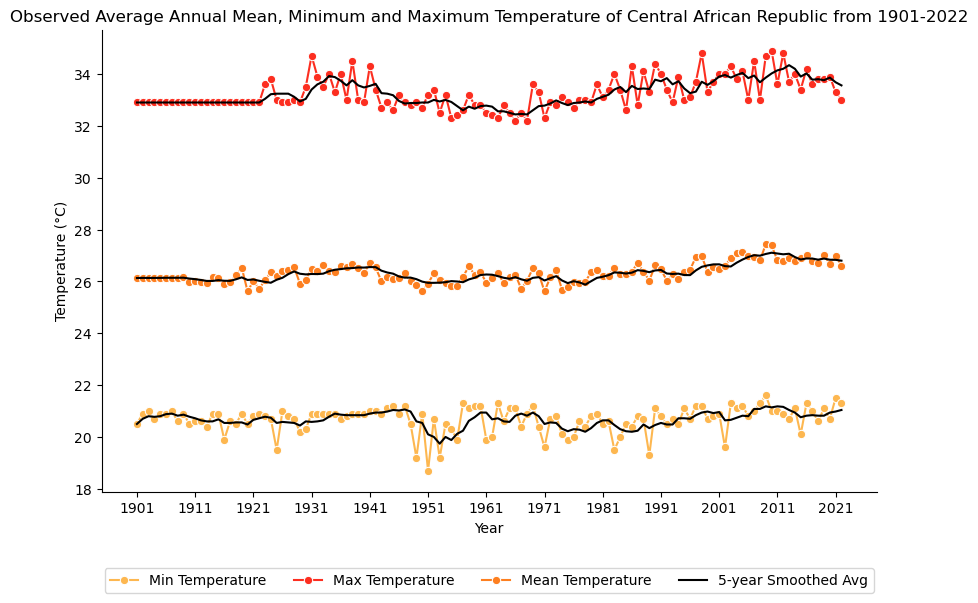

In [156]:
custom_colours = ["#FDB750", "#FC2E20","#FD7F20"]
plot_linegraph(df_stat, 'Min Temperature', 'Max Temperature','Mean Temperature', '5-year Smoothed Avg', 'Observed Average Annual Mean, Minimum and Maximum Temperature of Central African Republic from 1901-2022', 'Temperature (°C)', custom_colours)

### CAR Precipitation Profile

In [157]:
nc_file = "/Users/margretazuma/Desktop/climate_centre_data_analysis/data/cru_ts4.07.1901.2022.pre.dat.nc"
dataset = read_file(nc_file)
df = extract_data(dataset,'pre')

Dimension: lon, Size: 720
Dimension: lat, Size: 360
Dimension: time, Size: 1464
Variable name: lon, Shape: (720,)
Variable name: lat, Shape: (360,)
Variable name: time, Shape: (1464,)
Variable name: pre, Shape: (1464, 360, 720)
Variable name: stn, Shape: (1464, 360, 720)


In [158]:
df_time = add_time_metadata_to_dataframe(df)
df_stat = add_stats_metadata_to_dataframe(df_time, 'pre', 'Year')

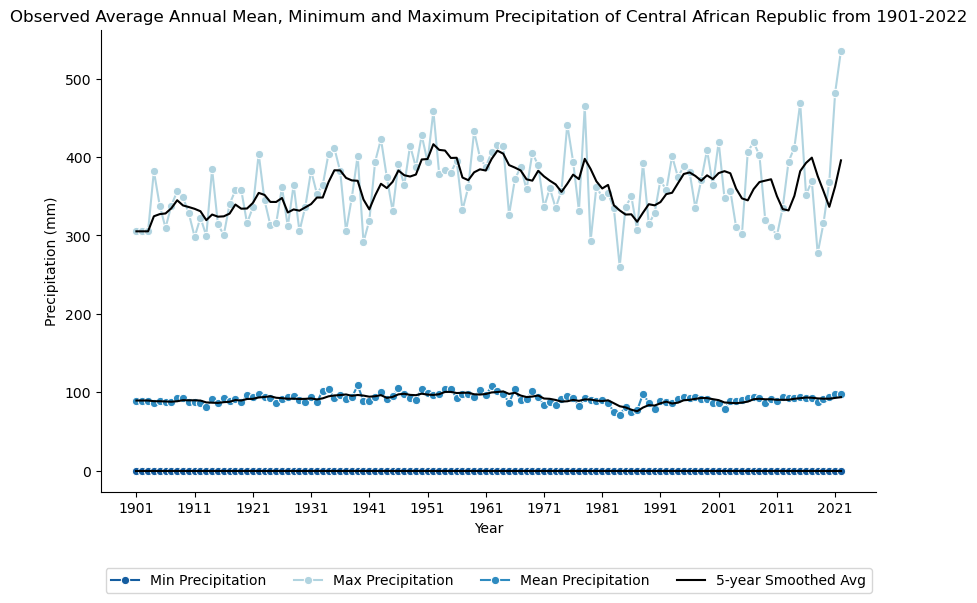

In [159]:
custom_colours = ["#145DA0", "#B1D4E0","#2E8BC0"]
plot_linegraph(df_stat, 'Min Precipitation', 'Max Precipitation','Mean Precipitation', '5-year Smoothed Avg', 'Observed Average Annual Mean, Minimum and Maximum Precipitation of Central African Republic from 1901-2022', 'Precipitation (mm)', custom_colours)

### CAR Diurnal Temperature Range Profile

In [160]:
nc_file = "/Users/margretazuma/Desktop/climate_centre_data_analysis/data/cru_ts4.07.1901.2022.dtr.dat.nc"
dataset = read_file(nc_file)
df = extract_data(dataset,'dtr')

Dimension: lon, Size: 720
Dimension: lat, Size: 360
Dimension: time, Size: 1464
Variable name: lon, Shape: (720,)
Variable name: lat, Shape: (360,)
Variable name: time, Shape: (1464,)
Variable name: dtr, Shape: (1464, 360, 720)
Variable name: stn, Shape: (1464, 360, 720)


In [161]:
df_time = add_time_metadata_to_dataframe(df)
df_stat = add_stats_metadata_to_dataframe(df_time, 'dtr', 'Year')

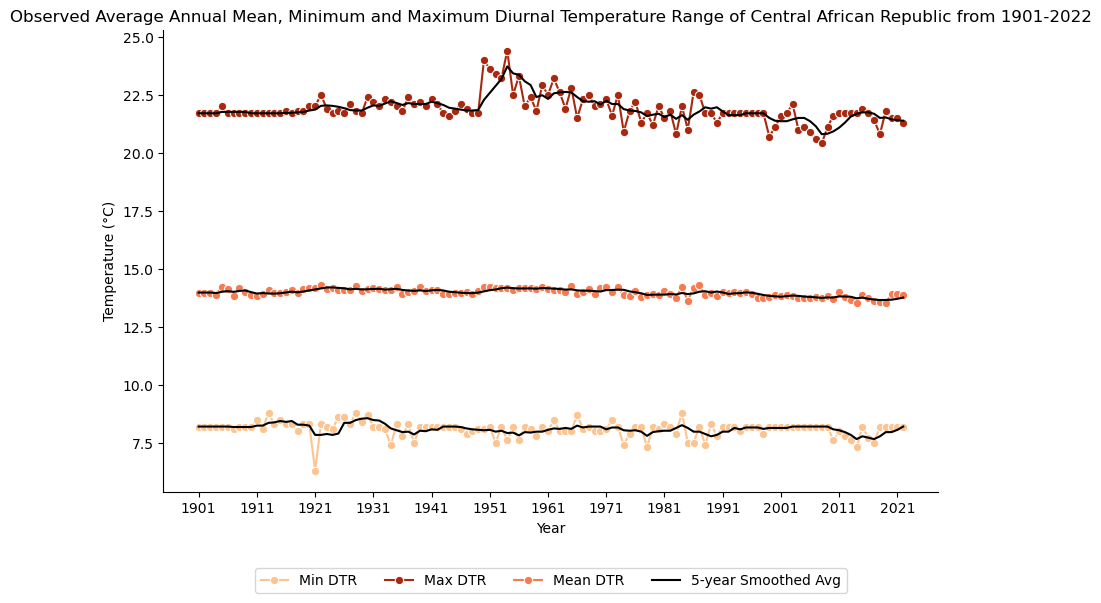

In [162]:
custom_colours = ["#FBC490", "#A82810","#F67B50"]
plot_linegraph(df_stat, 'Min DTR', 'Max DTR','Mean DTR', '5-year Smoothed Avg', 'Observed Average Annual Mean, Minimum and Maximum Diurnal Temperature Range of Central African Republic from 1901-2022', 'Temperature (°C)', custom_colours)

### CAR Precipitation and Temperature Monthly Profile 1901 - 2022

In [163]:
nc_file = "/Users/margretazuma/Desktop/climate_centre_data_analysis/data/cru_ts4.07.1901.2022.pre.dat.nc"
dataset = read_file(nc_file)
df_pre = extract_data(dataset,'pre')
df_time_pre = add_time_metadata_to_dataframe(df_pre)
df_stat_pre = add_stats_metadata_to_dataframe(df_time_pre, 'pre', 'Month')


Dimension: lon, Size: 720
Dimension: lat, Size: 360
Dimension: time, Size: 1464
Variable name: lon, Shape: (720,)
Variable name: lat, Shape: (360,)
Variable name: time, Shape: (1464,)
Variable name: pre, Shape: (1464, 360, 720)
Variable name: stn, Shape: (1464, 360, 720)


In [164]:
df_stat_pre['Month'] = df_stat_pre['Month'].astype('category')
# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_stat_pre['Month'] = pd.Categorical(df_stat_pre['Month'], categories=month_order, ordered=True)

In [165]:
nc_file = "/Users/margretazuma/Desktop/climate_centre_data_analysis/data/cru_ts4.07.1901.2022.tmp.dat.nc"
dataset = read_file(nc_file)
df_tmp = extract_data(dataset,'tmp')
df_time_tmp = add_time_metadata_to_dataframe(df_tmp)
df_stat_tmp = add_stats_metadata_to_dataframe(df_time_tmp, 'tmp', 'Month')

Dimension: lon, Size: 720
Dimension: lat, Size: 360
Dimension: time, Size: 1464
Variable name: lon, Shape: (720,)
Variable name: lat, Shape: (360,)
Variable name: time, Shape: (1464,)
Variable name: tmp, Shape: (1464, 360, 720)
Variable name: stn, Shape: (1464, 360, 720)


In [166]:
df_stat_tmp['Month'] = df_stat_tmp['Month'].astype('category')
# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_stat_tmp['Month'] = pd.Categorical(df_stat_tmp['Month'], categories=month_order, ordered=True)

In [167]:
def plot_combo_graph(dataframe1:pd.DataFrame, dataframe2:pd.DataFrame, label1:str, label2:str, label3: str, label4: str, title:str, list_of_colours:list):
    """
    Plots a combination graph with bar and line plots using Seaborn.

    Args:
        dataframe1 (pd.DataFrame): The first DataFrame containing temperature data.
        dataframe2 (pd.DataFrame): The second DataFrame containing precipitation data.
        label1 (str): Label for the first temperature line.
        label2 (str): Label for the second temperature line.
        label3 (str): Label for the third temperature line.
        label4 (str): Label for the precipitation bar plot.
        title (str): Title for the plot.
        list_of_colours (list): List of custom colors for the plot elements.

    Returns:
        None
    """
    sns.set_palette(list_of_colours)
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Use ax for bar plot
    sns.barplot(data=dataframe2, x='Month', y='Mean', label=label4, color='#003B73', alpha=0.7, ax=ax)
    ax.set_ylabel('Precipitation (mm)')
    x_ticks = ax.get_xticks()
    x_labels = ax.get_xticklabels()
    ax2 = ax.twinx()
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=90, ha='center')
    sns.lineplot(data=dataframe1, x='Month', y='Min', label=label1, marker='s', ax=ax2)
    sns.lineplot(data=dataframe1, x='Month', y='Max', label=label2, marker='s', ax=ax2)
    sns.lineplot(data=dataframe1, x='Month', y='Mean', label=label3, marker='s', ax=ax2)

    ax.set_xlabel('Month')
    ax2.set_ylabel('Temperature (°C)')
    lines1, labels1 = ax.get_legend_handles_labels()  # Legend handles and labels for ax
    lines2, labels2 = ax2.get_legend_handles_labels()  # Legend handles and labels for ax2
    all_lines = lines1 + lines2
    all_labels = labels1 + labels2
    plt.title(title)
    plt.legend(handles=all_lines, labels=all_labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.30))
    sns.despine()
    plt.show()

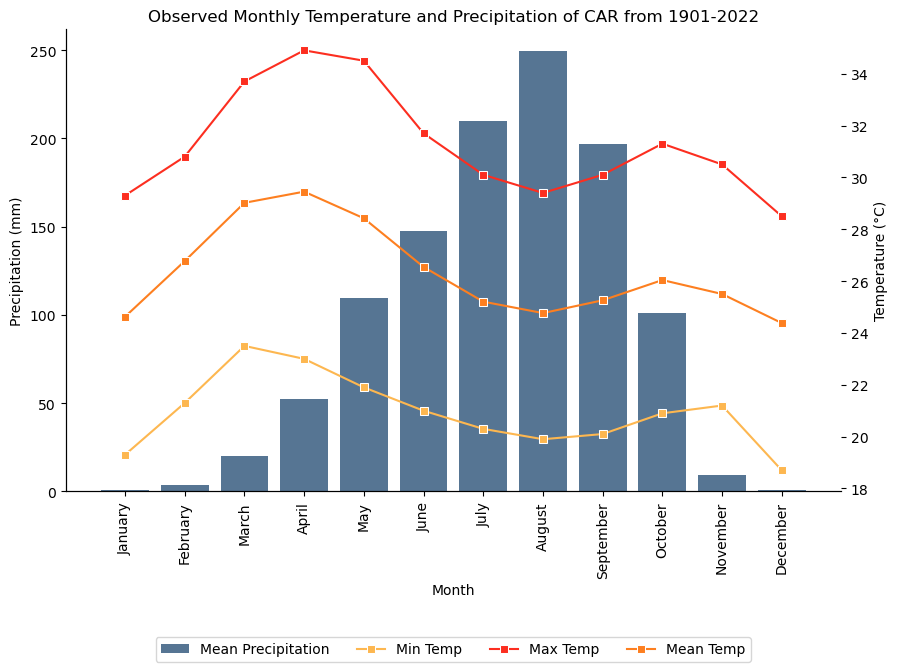

In [168]:
custom_colours = ["#FDB750", "#FC2E20","#FD7F20"]
plot_combo_graph(df_stat_tmp, df_stat_pre, "Min Temp", "Max Temp", "Mean Temp", "Mean Precipitation", "Observed Monthly Temperature and Precipitation of CAR from 1901-2022",custom_colours)